# Data Visualisations

# CPPN-NEAT vs ES-HyperNEAT

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Opens CPPN-NEAT and HyperNEAT run files
with open("result data/NEAT-250.pickle", "rb") as f:
    neat = pickle.load(f)

with open("result data/HYPERNEAT-250-FINAL.pickle", "rb") as f:
    es_hyperneat = pickle.load(f)

## Highest Fitness Xenobot in Each Generation

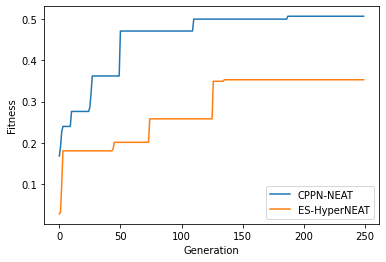

In [3]:
y = list(range(len(neat["best_each_gen"])))

plt.plot(y, neat["best_each_gen"])
plt.plot(y, es_hyperneat["best_each_gen"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])


## Standard Deviation of Fitness in Each Generation

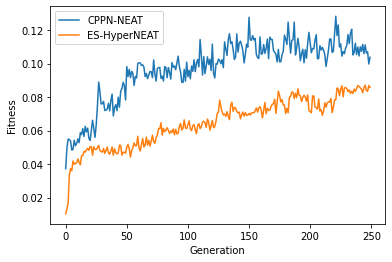

In [4]:
y = list(range(len(neat["std_dev"])))

plt.plot(y, neat["std_dev"])
plt.plot(y, es_hyperneat["std_dev"])

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])

## Mean Fitness

True


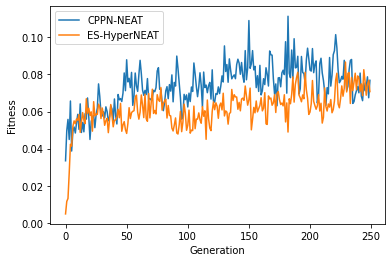

In [5]:
y = list(range(len(neat["mean"])))

plt.plot(y, neat["mean"])
plt.plot(y, es_hyperneat["mean"])

neat_50 = neat["mean"][50]
hyper_50 = es_hyperneat["mean"][50]

neat_m = (neat["mean"][-1] - neat_50) / (250 - 50)
hyper_m = (es_hyperneat["mean"][-1] - hyper_50) / (250 - 50)

print(neat_m < hyper_m)

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])

# Genotype-Phenotype Map Statistics

Load pickled data here

## CPPN-NEAT

### Log phenotype probability vs complexity

## ES-HyperNEAT

# Clustering of Xenobots

In [2]:
import json
import seaborn as sns
import tools.clustering
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split#

## By Structure

### Load dataset

In [10]:
f = open("motif_data.json")
data = json.load(f)

motifs = data["motifs"]
xenobots = data["xenobots"]
    
df = pd.DataFrame(xenobots)
    
df

,body,motif_counts
0,1111111011111100000100000000000000000000000000...,"{'3104908': 2, '1776355': 12, '2924825': 5, '3..."
1,0000000000000000000000000000000000000000000000...,{'766653': 180}
2,0000000100000011111111111111111111111111111111...,"{'883821': 1, '2271055': 1, '735840': 1, '2913..."
3,0001111001111101111110111111111111111111111111...,"{'254441': 1, '734992': 1, '2539331': 1, '1648..."
4,1111111000001100000000000000000000000000000000...,"{'183879': 3, '373486': 3, '320252': 1, '18357..."
...,...,...
478595,2211111111111101111110001111000000000000000000...,"{'360408': 1, '1052820': 2, '1648444': 96, '31..."
478596,0000000000000000000000000000000000000000000000...,"{'306723': 1, '3449100': 1, '32847': 1, '13370..."
478597,0000000000000000000000000000000000000000000000...,"{'766653': 59, '2536671': 5, '3310825': 1, '15..."
478598,1222221122222101222110112111001111100111110001...,"{'1938702': 1, '1612745': 1, '941606': 16, '55..."


### Preprocessing

## By Behaviour 